# AIDS Classification Project

# Imports

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbPipeline

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Tensorflow
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Functions

In [24]:
def check_class_imbalance(target:pd.Series):
    unique, counts = np.unique(target, return_counts=True)
    plt.figure(figsize=(10, 7))
    plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
    plt.title("Target Class Breakdown")
    plt.legend(unique)
    plt.show()
    
    plt.figure(figsize=(10, 7))
    sns.countplot(x=target)
    plt.xlabel("Target Classes")
    plt.ylabel("Counts")
    plt.show()

def view_dist_shape(df, type):
    plt.d
    
    

def create_sklearn_pipeline(model):
    
    return sklearn_pipeline(steps=[
        ("scaler", StandardScaler()),
        ("PowerTransformer", PowerTransformer()),
        ("model", model)
    ])

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def create_MLP_model(X, y):
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)
    
    scaler = StandardScaler()
    power_transformer = PowerTransformer("yeo-johnson")
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_transformed = power_transformer.fit_transform(X_train_scaled)
    X_test_transformed = power_transformer.transform(X_test_scaled)
    
    model = Sequential()
    model.add(Dense(32, input_dim=X_train_transformed.shape[1], activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    history = model.fit(X_train_transformed, y_train, epochs=100, batch_size=32, validation_split=0.2)
    test_loss, test_acc = model.evaluate(X_test_transformed, y_test)
    print(f"Test Accuracy: {test_acc:.2f}")
    predictions = model.predict(X_train_transformed)
    pred_classes = tf.argmax(predictions, axis=1)
    print(pred_classes)

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

# Problem Objective:

# We want to reduce the amount of false negatives as this can potentially destroy lives, however do we want a metric that favors solely suppressing false negatives over false positives? What is the ethical thing to do here? 

# To supress False negatives we focus on scoring by F2 score
# To give equal weight to false negatives and fale positives then we score by F1

# I don't know the legal or ethical requirements here, however I will base my model on the F1 score in this case.

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/AIDS_Classification.csv")
df

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,1,3,0,1,1,152,109,561,720,0
2135,395,0,17,102.9672,1,0,0,100,0,1,...,1,3,0,0,1,373,218,1759,1030,0
2136,1104,2,53,69.8544,1,1,0,90,0,1,...,1,3,0,1,0,419,364,1391,1041,0
2137,465,0,14,60.0000,1,0,0,100,0,0,...,0,1,0,0,0,166,169,999,1838,1


# Check For Nulls and Dupes

In [3]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

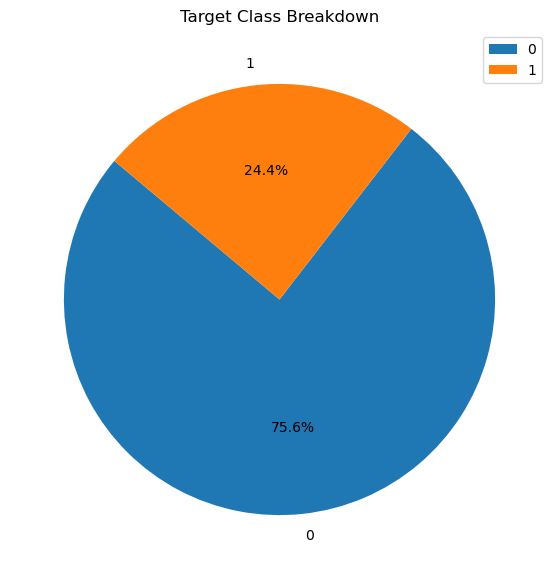

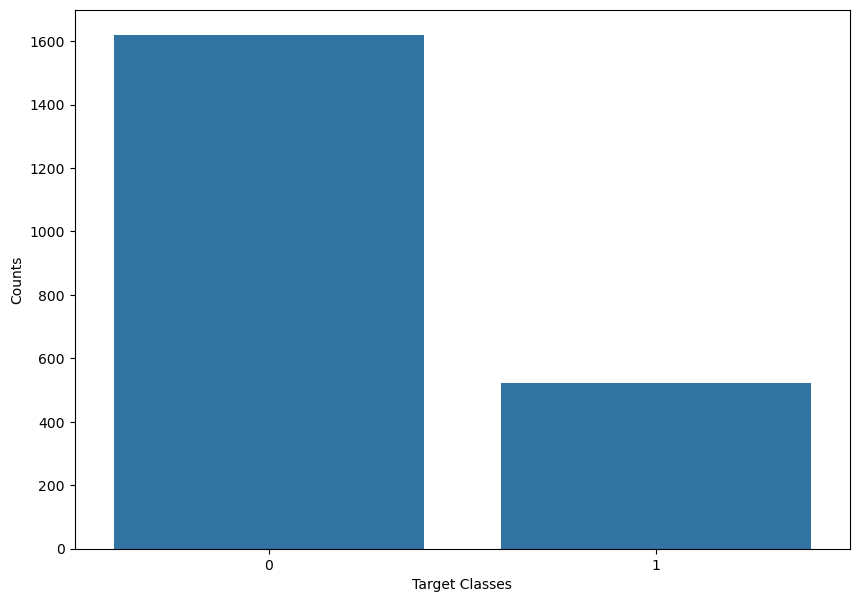

In [8]:
check_class_imbalance(df['infected'])

# Severe Class Imbalance exists

In [9]:
df.dtypes

time          int64
trt           int64
age           int64
wtkg        float64
hemo          int64
homo          int64
drugs         int64
karnof        int64
oprior        int64
z30           int64
preanti       int64
race          int64
gender        int64
str2          int64
strat         int64
symptom       int64
treat         int64
offtrt        int64
cd40          int64
cd420         int64
cd80          int64
cd820         int64
infected      int64
dtype: object

In [10]:
df.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,...,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,0.550257,...,0.585788,1.979897,0.172978,0.751286,0.362786,350.501169,371.307153,986.627396,935.369799,0.243572
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,0.497584,...,0.492701,0.899053,0.378317,0.432369,0.480916,118.573863,144.634909,480.197750,444.976051,0.429338
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,49.000000,40.000000,124.000000,0.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,263.500000,269.000000,654.000000,631.500000,0.000000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,2.000000,0.000000,1.000000,0.000000,340.000000,353.000000,893.000000,865.000000,0.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,423.000000,460.000000,1207.000000,1146.500000,0.000000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1199.000000,1119.000000,5011.000000,6035.000000,1.000000


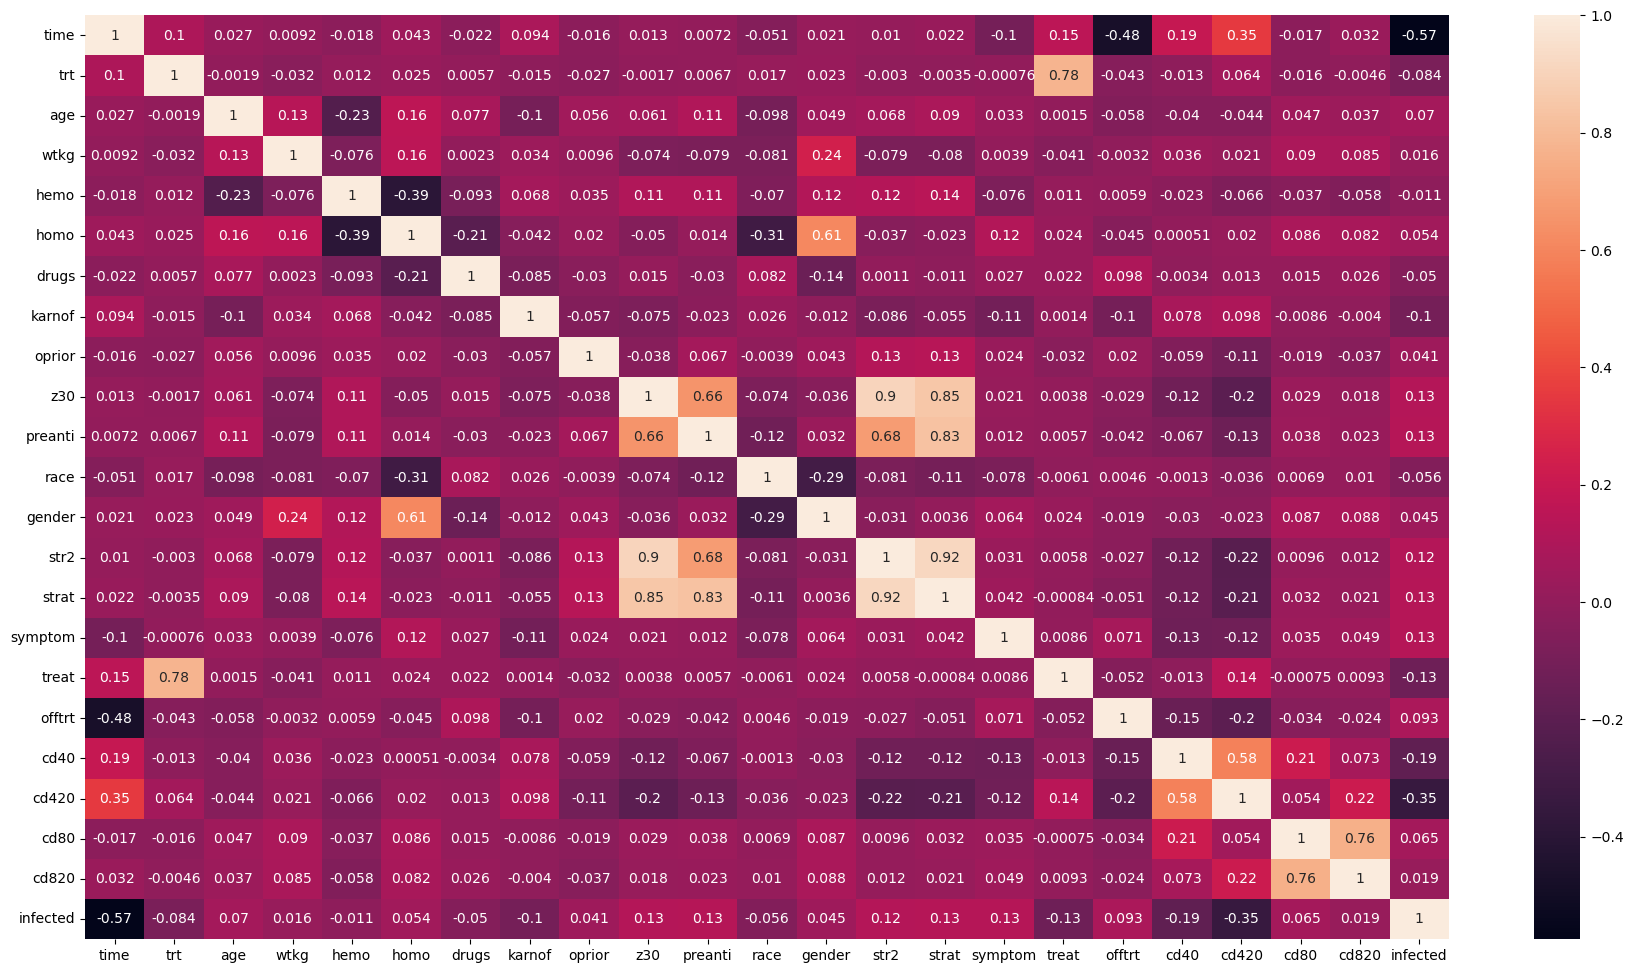

In [14]:
relations = df.corr()
plt.figure(figsize=(22, 12))
sns.heatmap(data=relations, annot=True)
plt.show()

In [ ]:
plt.figure(figsize=(16,16))

# Separate features

In [22]:
X, y = df.drop("infected", axis=1), df["infected"]

# Test Sequential Model

In [25]:
create_MLP_model(X, y)

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.4869 - accuracy: 0.7792 - val_loss: 0.4446 - val_accuracy: 0.7805
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8351 - val_loss: 0.3642 - val_accuracy: 0.8153
Epoch 3/100
36/36 [==============================] - 0s 1ms/step - loss: 0.2968 - accuracy: 0.8665 - val_loss: 0.3255 - val_accuracy: 0.8432
Epoch 4/100
36/36 [==============================] - 0s 940us/step - loss: 0.2640 - accuracy: 0.8848 - val_loss: 0.3487 - val_accuracy: 0.8432
Epoch 5/100
36/36 [==============================] - 0s 991us/step - loss: 0.2398 - accuracy: 0.9058 - val_loss: 0.3056 - val_accuracy: 0.8571
Epoch 6/100
36/36 [==============================] - 0s 958us/step - loss: 0.2207 - accuracy: 0.9058 - val_loss: 0.3458 - val_accuracy: 0.8676
Epoch 7/100
36/36 [==============================] - 0s 973us/step - loss: 0.2105 - accuracy: 0.9101 - val_loss: 0.3085 - val_accuracy: 0.8641
Epoch